In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import svm, model_selection
from sklearn.model_selection import KFold

# this one is only needed if you want to use dictionary in getOptimalSVM
import operator

# use seaborn plotting defaults
import seaborn as sns 
sns.set()
data = np.loadtxt('data/dataSVM.txt')

features = data[0:int(len(data) * 0.8), :-1]
labels = data[0:int(len(data) * 0.8), 2]
testingFeatures = data[int(len(data) * 0.8):, :-1]
testingLabels = data[int(len(data) * 0.8):, 2]


print(features.shape)
print(labels.shape)
print(testingFeatures.shape)
print(testingLabels.shape)

(800, 2)
(800,)
(200, 2)
(200,)


In [2]:
def plot_decision_boundary(clf, X, Y, cmap = 'Paired_r'):
    """
    This function visualizes the input data X, colored according to labels Y, 
    superimposed over the decision boundary of the classifier clf
    
    """
    
    h = 0.02
    x_min, x_max = X[:,0].min() - 10*h, X[:,0].max() + 10*h
    y_min, y_max = X[:,1].min() - 10*h, X[:,1].max() + 10*h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(5,5))
    plt.contourf(xx, yy, Z, cmap = cmap, alpha = 0.25)
    plt.contour(xx, yy, Z, colors = 'k', linewidths = 0.7)
    plt.scatter(X[:,0], X[:,1], c = Y, cmap = cmap, edgecolors = 'k');
    

In [47]:
#NOTE: it is only allowed to use imports specified at the top of the document, you should not write any addional import

class CrossValidation_SVM:
    
    def __init__(self, n_folds = 5, parameterCList = [0.001, 0.01, 0.1, 1, 10, 100]):
        """
        Initializes the cross-validation class.
        
        Parameters
        ----------
        n_folds : the number of folds we expect to use for cross-validation
        """
        
        self.n_folds = n_folds
        self.parameterCList = parameterCList
    
    def __generateNextSplit(self, features, labels, train, test):
        """
        Use this function to generate the next split of the input features and labels into 
        training and validation parts
        
        Parameters
        ----------
        features : Array of shape NxM
        labels   : Array of length N
        kfold    : iterator
        
        N is the number of samples, M is the number of features
        
        Returns
        -------
        trainingFeatures   : subportion of the features selected for training using the current split
        trainingLabels     : subportion of the labels selected for training using the current split
        validationFeatures : subportion of the features selected for validation using the current split
        validationLabels   : subportion of the labels selected for validation using the current split
        """
        trainingFeatures   = None
        trainingLabels     = None
        validationFeatures = None
        validationLabels = None    
        trainingFeatures, trainingLabels, validationFeatures, validationLabels = \
        features[train], labels[train], features[test], labels[test]    
        return trainingFeatures, trainingLabels, validationFeatures, validationLabels
    
    def __computeErrorForSpecificC(self, features, labels, C):
        """
        Iterate throught all splits and compute the SVM performance using the specified C.
        Use a linear kernel for the SVM.

        Parameters
        ----------
        features : Array of shape NxM
        labels   : Array of length N
        C : svm regularization parameter
        
        Returns
        -------
        meanAccuracy : mean validation accuracy computer over all splits
        """         
        
        accuracyArray = []
        
        # this function should use __generateNextSplit for iterating over splits
        # The iterator over folds. If you don't want to use it, feel free to implement your own iterator
        kfold = KFold(self.n_folds, shuffle = False)
        for train, test in kfold.split(features):
            x_train, t_train, x_test, t_test = self.__generateNextSplit(features, labels, train, test)
            SVM = svm.SVC(C, kernel = 'linear')
            SVM.fit(x_train, t_train)
            #print(SVM.score(x_test, t_test))
            accuracyArray.append(SVM.score(x_test, t_test))
        return np.mean(accuracyArray)
    
    def getOptimalSVM(self, features, labels):
        """
        Iterate through all C from self.parameterCList to find the optimal one, and generate the corresponding SVM classifier

        Parameters
        ----------
        features : Array of shape NxM
        labels   : Array of length N
        
        Returns
        -------
        clf : the optimal SVM classfier trained on all input features and labels using optimal C
        accuracyList : the list of mean accuracies for each C from self.parameterCList.
                       accuracyList should be of the length len(self.parameterCList) 
        """
        
        accuracyList = {}
        # if you want and know how, you can use dictionary here: accuracyDict = {}
        # TODO: ADD YOUR CODE HERE
        #   1) go through all C in self.parameterCList using __computeErrorForSpecificC
        for C in self.parameterCList: 
            accuracyList[C] = self.__computeErrorForSpecificC(features, labels, C)    
        #   3) find the optimal C with the highest mean accuracy
        bestC = max(accuracyList, key = lambda k: accuracyList[k])
        #   4) train clf on all input features and label using the optimal C
        clf = svm.SVC(bestC, kernel = 'linear')
        clf.fit(features, labels)
        
        return clf, accuracyList
        

{0.001: 0.9225, 0.01: 0.92125, 0.1: 0.9274999999999999, 1: 0.9237500000000001, 10: 0.9237500000000001, 100: 0.9237500000000001}


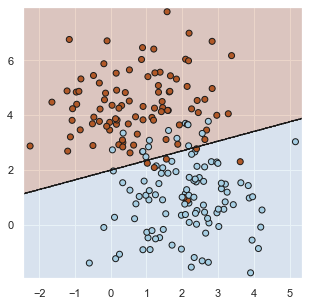

In [48]:
#this is the code to test your cross-validation implementation.
tester = CrossValidation_SVM(n_folds = 5, parameterCList = [0.001, 0.01, 0.1, 1, 10, 100])
clf, accuracyList = tester.getOptimalSVM(features, labels)
print(accuracyList)
plot_decision_boundary(clf, testingFeatures, testingLabels)